# Flight departure delay predictions

##  Problem Statement

Flight delays represent a big issue in the air travel industry. Delays cause huge losses to airlines, impact passenger satisfaction and cause complex logistic problems. Because of this, it is crucial for airlines to better understand flight delays, in order to minimize the impact in their business.

There are many things that can cause a flight to be delayed, going from aircraft maintenance, extreme weather, airport operations, security and screening activities, a previous flight delay causing the next flight to depart late, among many others. Because there are many moving parts in the air travel operations, solving the delay problem is quite complex.

The ability to implement a model that predicts flight delays accurately would have a significant positive impact on overall airline operations.  Airlines would be able to minimize the impact of such delays by making changes on passenger itineraries, flight routes, crew assignments, aircraft schedules and maintenance, etc.

The main purpose of this study is to create a model to predict departure delay for flights in the US, where a delay is a 15-minute or more delay from planned, using a subset of the flight's on-time performance data provided by the United States Bureau of Transportation Statistics. The data comprises of flights departing from all major US airports in 2019.

## Package imports, directories and configuration

In [ ]:
# install package to find timezone based on longitude and latitude
%pip install timezonefinder

In [0]:
# package imports
from pyspark.sql.window import Window
from pyspark.sql import SQLContext
from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, OneHotEncoder , VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
import pyspark.sql.functions as F
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import PCA
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col, isnull, broadcast, udf, count, when, isnan, lpad, to_timestamp, concat, to_utc_timestamp, expr, unix_timestamp, avg, round, lag, to_date, row_number, explode, array, lit, hour
from pyspark.sql.window import Window
from pyspark.sql import SQLContext
from pyspark.sql.types import DoubleType


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_squared_error

import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from timezonefinder import TimezoneFinder

import mlflow
import mlflow.spark


In [0]:
# spark configuration
sc = spark.sparkContext
sqlContext = SQLContext(sc)
# sc.getConf().getAll()

## Exploratory data analysis (EDA)

An extensive EDA is performed with the data. The main results are shown below.

In [0]:
# Load 2019 data
df_airlines = spark.read.parquet("/data/parquet_airlines_data/*")
df_airlines = df_airlines.where((col('YEAR') == 2019))

### Check for duplicates

Data has duplicates. Every row is duplicated.

In [0]:
#Check Duplicates
print(df_airlines.count())
df_airlines = df_airlines.dropDuplicates()
print(df_airlines.count())

14844074
7422037

### Descriptive statistics

Descriptive statistics provide basic information about the variables in the dataset and might highlight relationships between variables.

In [0]:
df_airlines_summary = spark.createDataFrame(df_airlines.describe().toPandas())

In [0]:
display(df_airlines_summary)

summary,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME,DIV_AIRPORT_LANDINGS,DIV_REACHED_DEST,DIV_ACTUAL_ELAPSED_TIME,DIV_ARR_DELAY,DIV_DISTANCE,DIV1_AIRPORT,DIV1_AIRPORT_ID,DIV1_AIRPORT_SEQ_ID,DIV1_WHEELS_ON,DIV1_TOTAL_GTIME,DIV1_LONGEST_GTIME,DIV1_WHEELS_OFF,DIV1_TAIL_NUM,DIV2_AIRPORT,DIV2_AIRPORT_ID,DIV2_AIRPORT_SEQ_ID,DIV2_WHEELS_ON,DIV2_TOTAL_GTIME,DIV2_LONGEST_GTIME,DIV2_WHEELS_OFF,DIV2_TAIL_NUM,DIV3_AIRPORT,DIV3_AIRPORT_ID,DIV3_AIRPORT_SEQ_ID,DIV3_WHEELS_ON,DIV3_TOTAL_GTIME,DIV3_LONGEST_GTIME,DIV3_WHEELS_OFF,DIV3_TAIL_NUM,DIV4_AIRPORT,DIV4_AIRPORT_ID,DIV4_AIRPORT_SEQ_ID,DIV4_WHEELS_ON,DIV4_TOTAL_GTIME,DIV4_LONGEST_GTIME,DIV4_WHEELS_OFF,DIV4_TAIL_NUM,DIV5_AIRPORT,DIV5_AIRPORT_ID,DIV5_AIRPORT_SEQ_ID,DIV5_WHEELS_ON,DIV5_TOTAL_GTIME,DIV5_LONGEST_GTIME,DIV5_WHEELS_OFF,DIV5_TAIL_NUM
count,7422037,7422037,7422037,7422037,7422037,7422037,7422037,7422037,7422037,7404200,7422037,7422037,7422037,7422037,7422037,7422037,7422037,7422037,7422037,7422037,7422037,7422037,7422037,7422037,7422037,7422037,7422037,7422037,7422037,7422037,7291951,7291927,7291927,7291927,7291927,7422037,7288060,7288060,7284390,7284390,7422037,7284391,7268232,7268232,7268232,7268232,7422037,7422037,134925,7422037,7421902,7268232,7268232,7422037,7422037,7422037,1389253,1389253,1389253,1389253,1389253,51136,51135,51135,7422037,18880,16158,16159,18873,19828,19828,19828,19828,19828,19828,16249,16249,154,155,155,154,154,154,66,66,3,3,3,3,3,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
mean,2019.0,2.5258253226169582,6.578750011620799,15.73195876010858,3.9371547191155205,null,null,19986.76164036908,null,null,2557.1959405483967,12648.880516763795,1264891.9722360587,31744.700892086632,null,null,null,27.051897881942654,null,54.03271473855493,12648.811283883386,1264885.048915143,31744.684801625215,null,null,null,27.052409197097777,null,54.03308108003234,1330.2585073343073,1334.6063107116327,10.923267333861132,14.10478176756295,0.1868043934065714,0.08095898381868058,null,17.389349291855446,1358.2643895632034,1459.031755026845,7.740775823370248,1485.7895525177253,1462.9553246112132,5.414849168270909,14.167795276760566,0.19114043140064874,-0.18382448441381619,null,0.018178971621941525,null,0.002543776055010235,141.90216133276888,136.690302400914,111.57339996852055,1.0,800.5436574891771,3.676005387739242,21.128592128287647,3.8024038817983477,16.587946184028397,0.09608329080448269,27.40747869538522,1343.6482126095118,40.23840813532805,39.61257455754376,0.0037119189785769055,0.8558792372881356,408.0935140487684,264.9022216721332,35.31198007735919,null,12690.940336897316,1269097.630421626,1498.3232297760742,37.96792414766996,30.821716764171878,1523.493138039264,null,null,12428.709677419354,1242874.8903225807,1385.2142857142858,26.62987012987013,22.714285714285715,1371.878787878788,null,null,13436.333333333334,1343635.3333333333,1603.0,29.666666666666668,24.0,853.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
stddev,0.0,1.1059138396658752,3.4025850139692158,8.762182523637827,1.9958138300354695,null,null,374.7510885121161,null,null,1799.4134083080812,1523.8478640171033,152384.55808081682,1304.6797693101291,null,null,null,16.456969709188844,null,26.1624713156

### Data imbalance

- The dataset is not balanced.
- Non delayed flights are ~ 4 times bigger then delayed flights.
- Potential problem for most classification algorithms as they are designed on the assumption of an equal number of observations in each class.
- The balance will also need to be checked in the final dataset by either resampling the training set or using a SMOTE method.

In [0]:
#Make it available to sql
df_airlines.createOrReplaceTempView("df_airlines")

In [0]:
%sql 
DROP TABLE IF EXISTS airlines_data; CREATE TABLE airlines_data AS SELECT * FROM df_airlines; 

num_affected_rows,num_inserted_rows


In [0]:
%sql 
SELECT 
  'Delay >= 15 min' DelayType, 
   count(*) Flight_CNT
FROM airlines_data
WHERE DEP_DEL15 = 1
UNION ALL
SELECT 
  'Delay < 15 min' Delay_Type, 
   count(*) Flight_CNT
FROM airlines_data
WHERE DEP_DEL15 = 0

DelayType,Flight_CNT
Delay >= 15 min,1362164
Delay < 15 min,5929763


### Delay Length

- Majority of the delays are under 30 minutes.
- However, some extreme delays exists where the delay is more than 1000 minutes, histogram has a very long tail.
- Small group of flights leaves early.

In [ ]:
%sql 
SELECT 
  DEP_DELAY
FROM airlines_data

### Delay by departure time
Delays appear to happen later in the day, most likely as the day progresses the chances are higher that the airplane was delayed on another trip.

Out[98]:

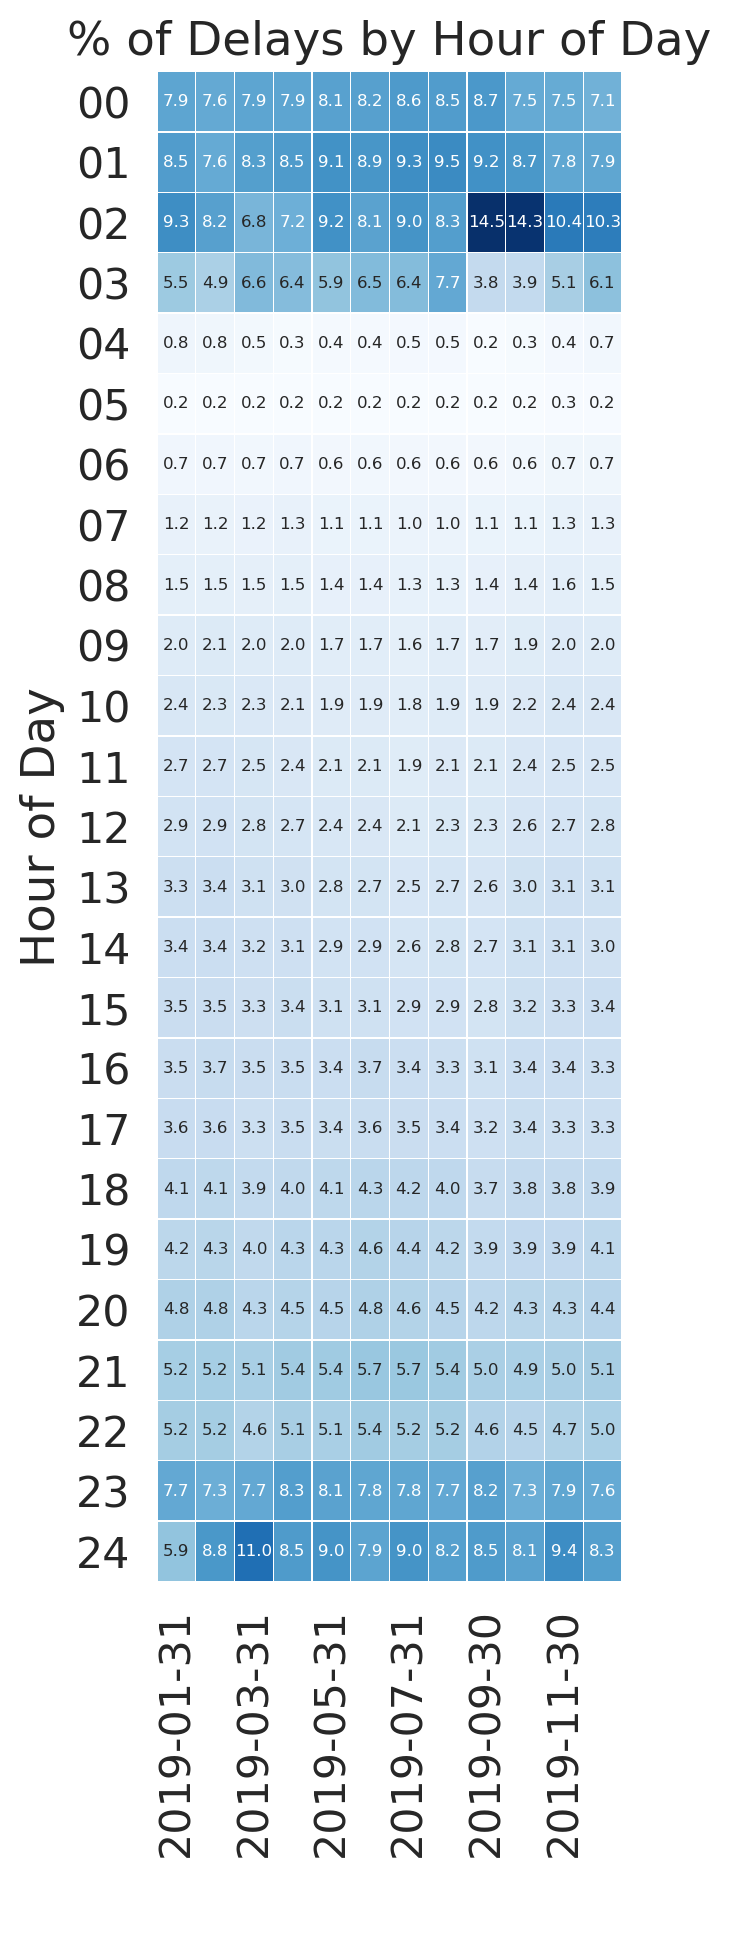

(array([ 0.5, 2.5, 4.5, 6.5, 8.5, 10.5]),
 <a list of 6 Text major ticklabel objects>)

In [0]:
df_temp = sqlContext.sql(""" 
SELECT 
  A.Date date,
  A.var,
  (B.cnt / cast(A.cnt as float)) * 100 as cnt
FROM 
    (
    SELECT 
      last_day(AN.FL_DATE) date, 
      lpad(cast(cast(AN.DEP_TIME/100 as int) as string),2,'0') var, 
      count(*) cnt
    FROM airlines_data AN
    GROUP BY last_day(AN.FL_DATE), lpad(cast(cast(AN.DEP_TIME/100 as int) as string),2,'0')
  ) A
  LEFT JOIN
  (
  SELECT 
      last_day(BN.FL_DATE) date, 
      lpad(cast(cast(BN.DEP_TIME/100 as int) as string),2,'0') var, 
      count(*) cnt
    FROM airlines_data BN
    WHERE BN.DEP_DEL15 = 1
    GROUP BY last_day(BN.FL_DATE), lpad(cast(cast(BN.DEP_TIME/100 as int) as string),2,'0')    
  ) B
ON A.date = B.date AND A.var = B.var
WHERE A.var is not null
""")

DATA_DF = df_temp.toPandas()
DATA_DF_GB = DATA_DF.groupby(by=["date"]).sum()
DATA_DF_GB.reset_index(inplace=True)

col_join = ['date']
return_df = pd.merge(DATA_DF, DATA_DF_GB, left_on=col_join, right_on=col_join)
return_df["cnt"] = (return_df["cnt_x"] / return_df["cnt_y"]) * 100

DATA_DFP = return_df.pivot(index='var', columns='date', values='cnt')
sns.set(font_scale=1.4)
fig = plt.figure(figsize=(3, 10),frameon =True, dpi=200)  
fig = sns.heatmap(DATA_DFP,annot=True,cbar=False,linewidths=0.1,annot_kws={"size": 6},fmt='0.1f', square=False,cmap="Blues") 
fig.set(xlabel=' ', ylabel='Hour of Day',title=("% of Delays by Hour of Day"))
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 

### Delay by Operator

- Delays occur more/less for certain operators.
- Operators F9 and B6 appear to have consistent delays.

Out[99]:

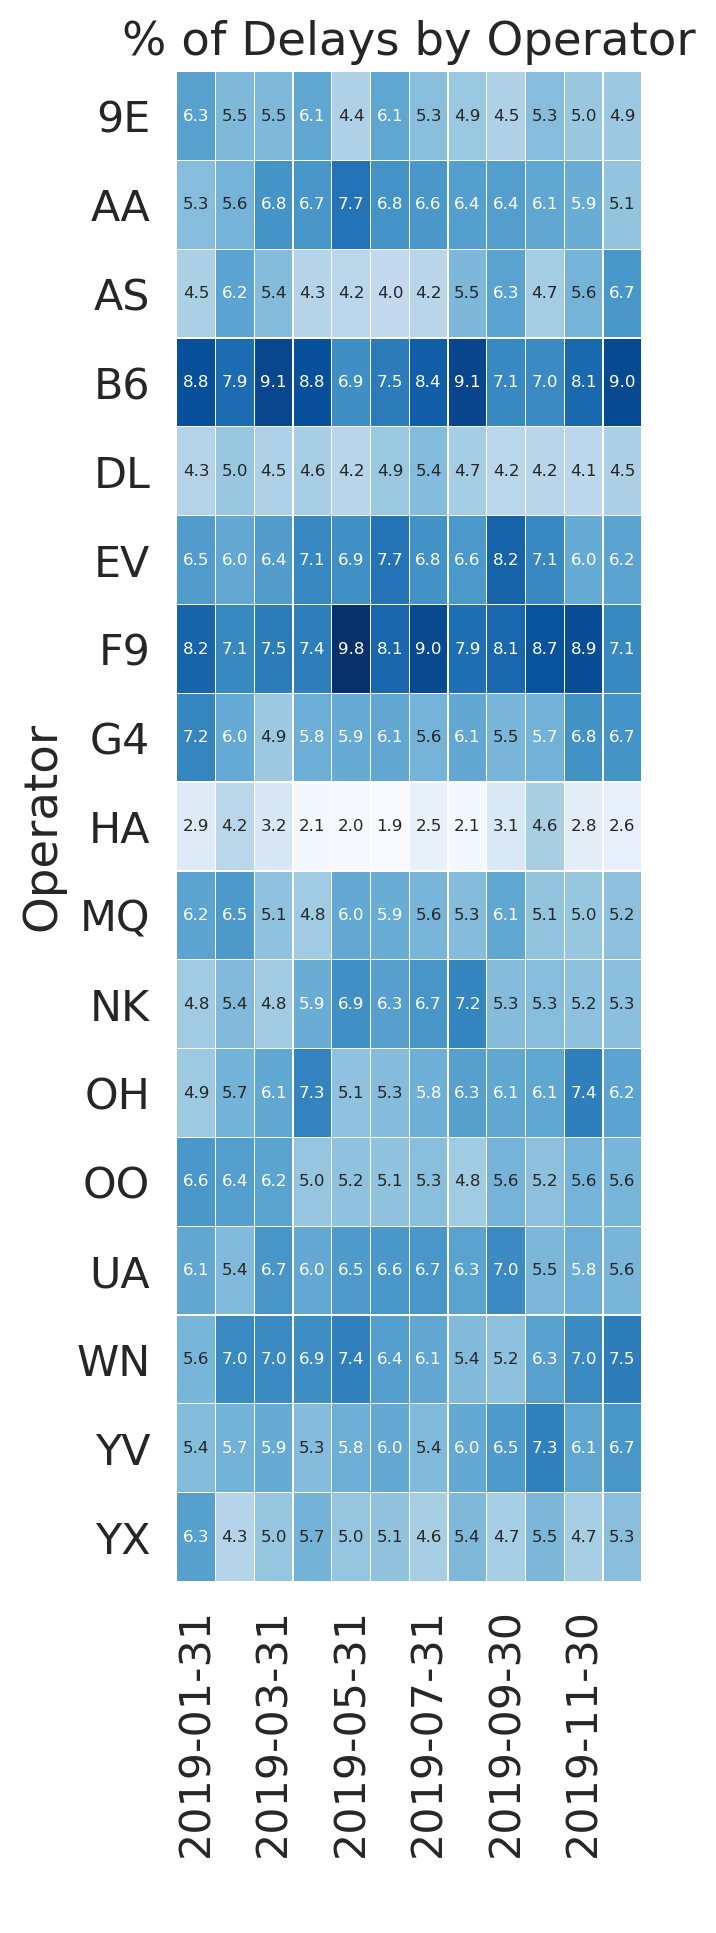

(array([ 0.5, 2.5, 4.5, 6.5, 8.5, 10.5]),
 <a list of 6 Text major ticklabel objects>)

In [0]:
df_temp = sqlContext.sql(""" 
SELECT 
  A.Date date,
  A.OP_CARRIER var,
  (B.cnt / cast(A.cnt as float)) * 100 as cnt
FROM 
    (
    SELECT 
      last_day(AN.FL_DATE) date, 
      AN.OP_CARRIER, 
      count(*) cnt
    FROM airlines_data AN
    GROUP BY last_day(AN.FL_DATE), AN.OP_CARRIER
  ) A
  LEFT JOIN
  (
  SELECT 
      last_day(BN.FL_DATE) date, 
      BN.OP_CARRIER, 
      count(*) cnt
    FROM airlines_data BN
    WHERE BN.DEP_DELAY >= 15
    GROUP BY last_day(BN.FL_DATE), BN.OP_CARRIER    
  ) B
ON A.date = B.Date AND A.OP_CARRIER = B.OP_CARRIER
""")

DATA_DF = df_temp.toPandas()
DATA_DF_GB = DATA_DF.groupby(by=["date"]).sum()
DATA_DF_GB.reset_index(inplace=True)

col_join = ['date']
return_df = pd.merge(DATA_DF, DATA_DF_GB, left_on=col_join, right_on=col_join)
return_df["cnt"] = (return_df["cnt_x"] / return_df["cnt_y"]) * 100

DATA_DFP = return_df.pivot(index='var', columns='date', values='cnt')
sns.set(font_scale=1.4)
fig = plt.figure(figsize=(3, 10),frameon =True, dpi=200)     
fig = sns.heatmap(DATA_DFP,annot=True,cbar=False,linewidths=0.1,annot_kws={"size": 6},fmt='0.1f', square=False,cmap="Blues") 
fig.set(xlabel=' ', ylabel='Operator',title=("% of Delays by Operator"))
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 


### Variable's correlation

Correlation heatmap to quickly visualize if any linear relationship exists among the features. 

- Some features are correlated and will need to be removed.
- Many correlated features.
- Nothing strongly correlated to delay label.

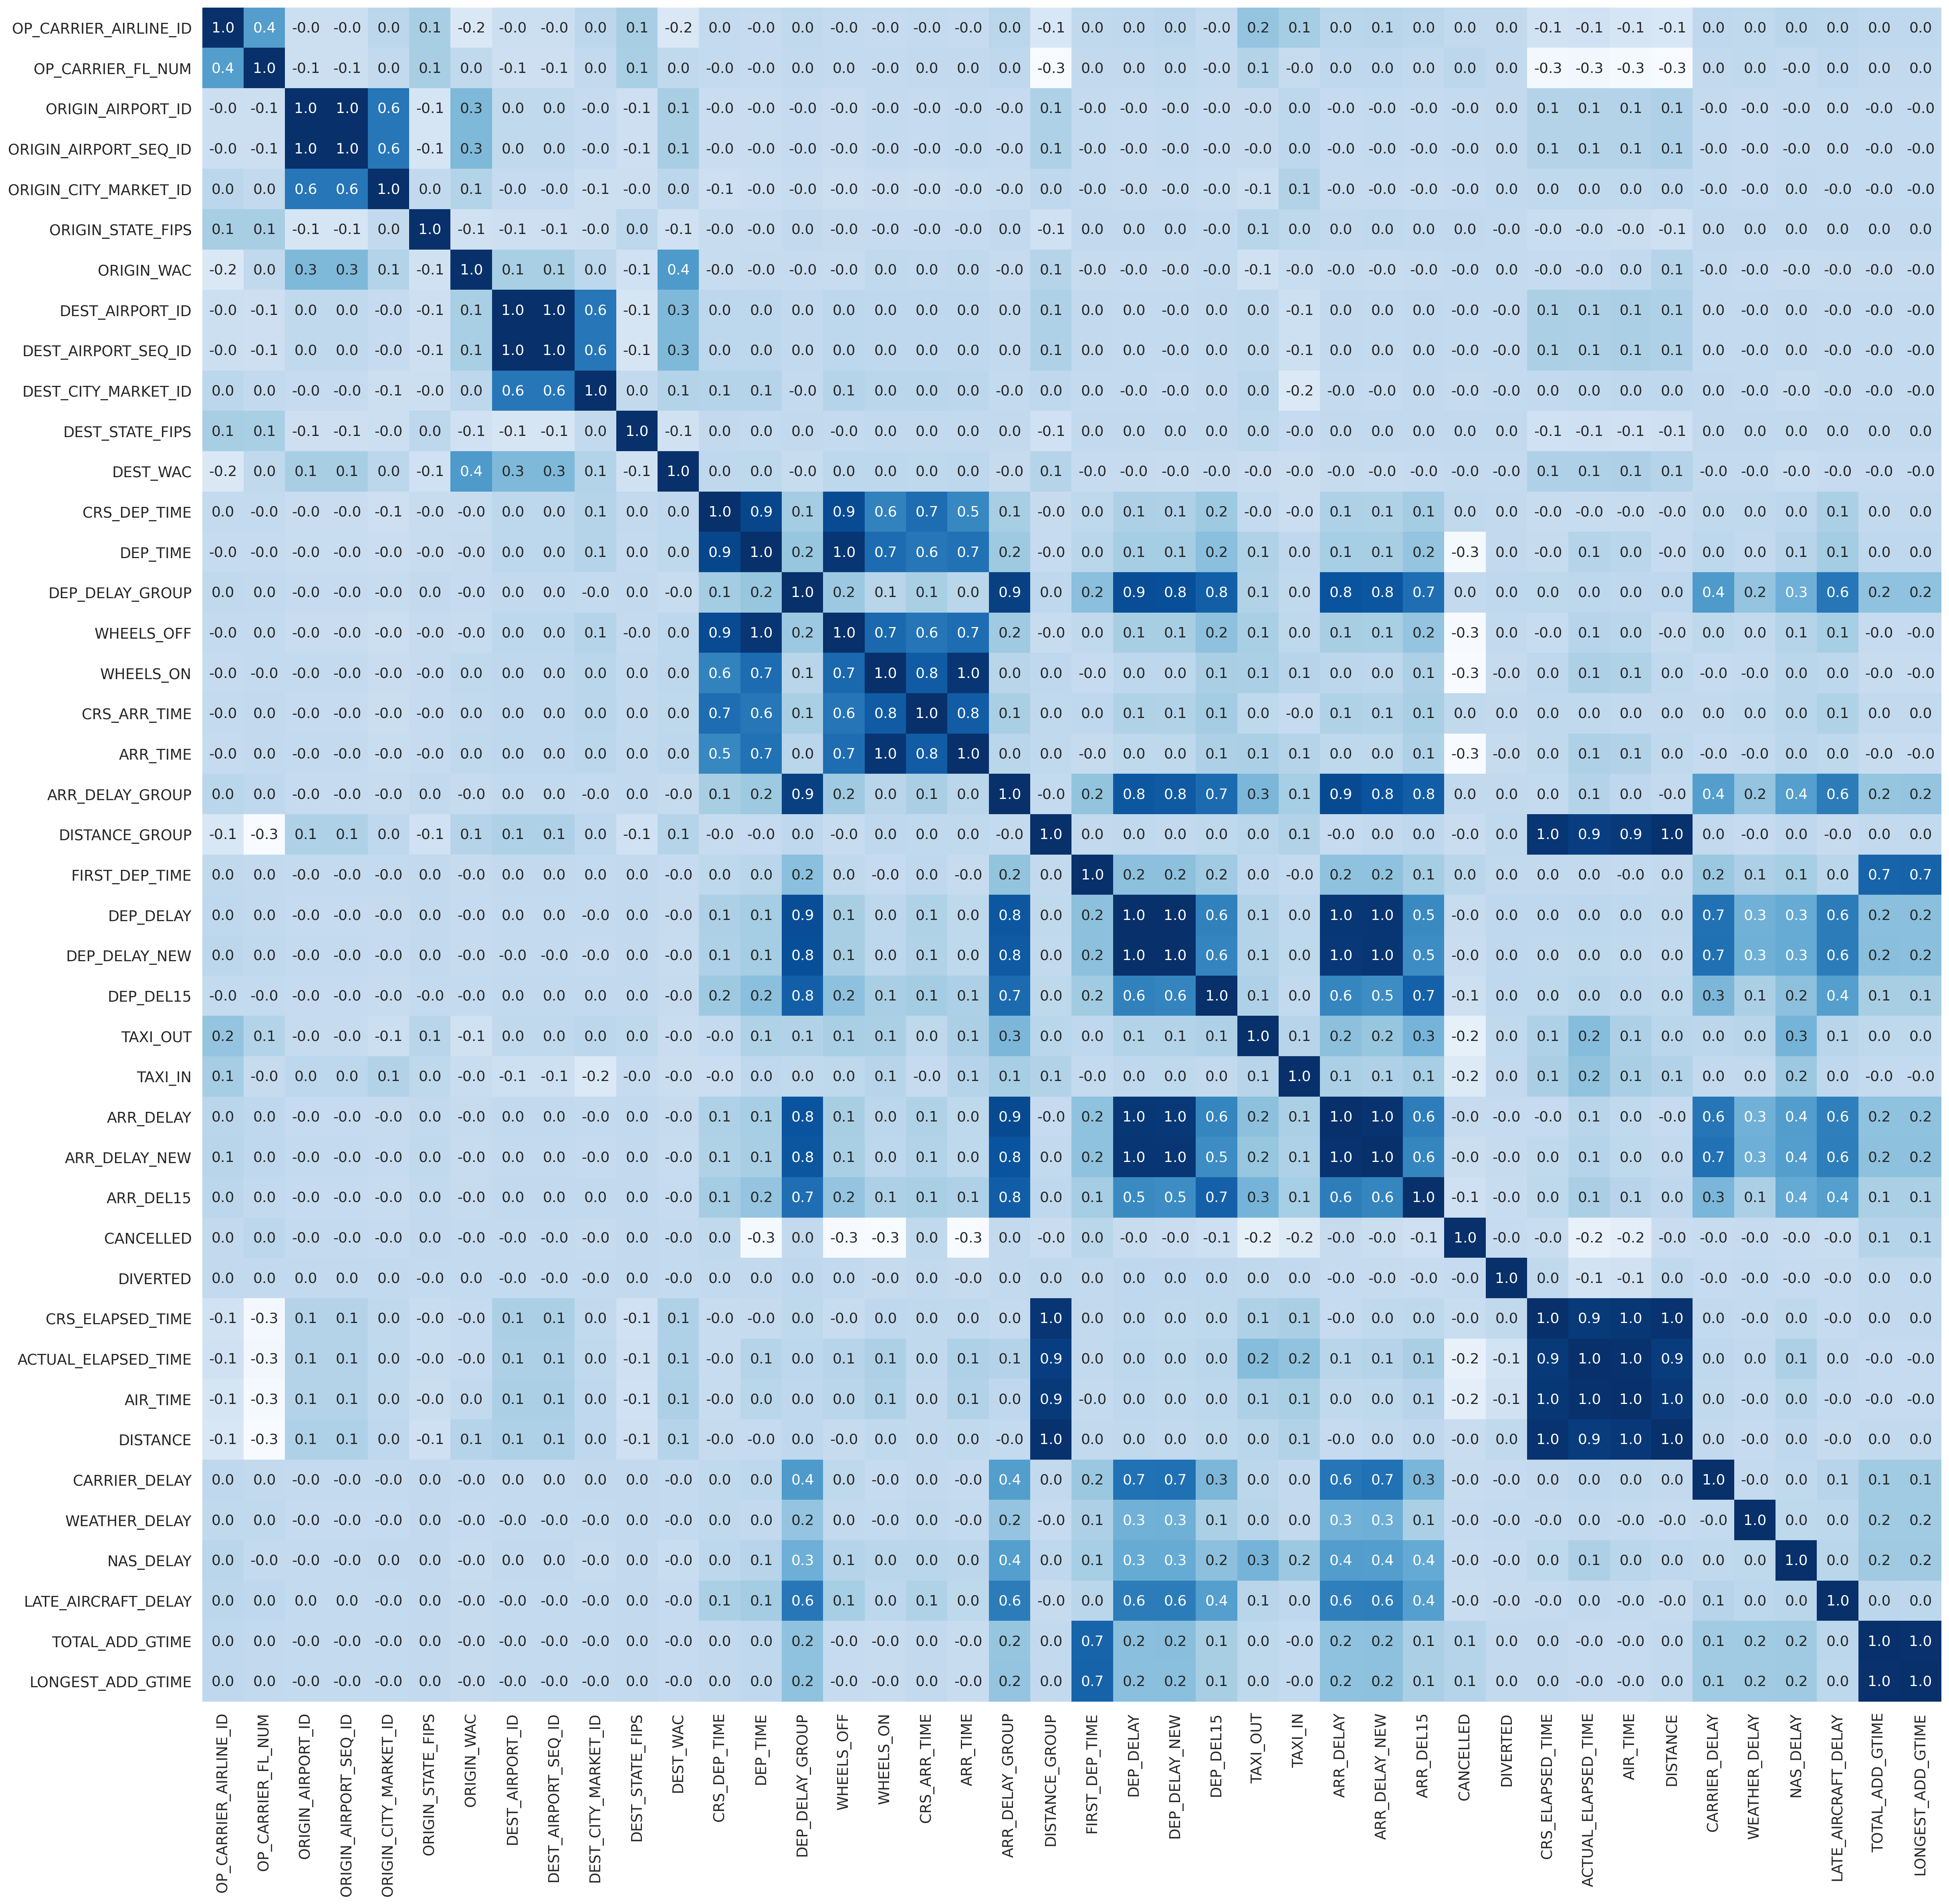

In [0]:
df_airlines_clean = sqlContext.sql(""" SELECT * FROM airlines_data""")
df_airlines_clean = df_airlines_clean.drop("DIV4_WHEELS_OFF",
"DIV4_TAIL_NUM","DIV5_AIRPORT","DIV5_AIRPORT_ID","DIV5_AIRPORT_SEQ_ID","DIV5_WHEELS_ON","DIV5_TOTAL_GTIME","DIV5_LONGEST_GTIME","DIV5_WHEELS_OFF",
"DIV5_TAIL_NUM","DIV3_WHEELS_OFF","DIV3_TAIL_NUM","DIV4_AIRPORT","DIV4_AIRPORT_ID","DIV4_AIRPORT_SEQ_ID","DIV4_WHEELS_ON","DIV4_TOTAL_GTIME",
"DIV4_LONGEST_GTIME","DIV4_WHEELS_OFF","DIV3_WHEELS_OFF","DIV3_TAIL_NUM","DIV4_AIRPORT","DIV4_AIRPORT_ID","DIV4_AIRPORT_SEQ_ID","DIV4_WHEELS_ON",
"DIV4_TOTAL_GTIME","DIV4_LONGEST_GTIME","DIV2_TOTAL_GTIME","DIV2_LONGEST_GTIME","DIV2_WHEELS_OFF","DIV2_TAIL_NUM","DIV3_AIRPORT","DIV3_AIRPORT_ID",
"DIV3_AIRPORT_SEQ_ID","DIV3_WHEELS_ON","DIV3_TOTAL_GTIME","DIV3_LONGEST_GTIME","DIV2_TOTAL_GTIME","DIV2_LONGEST_GTIME","DIV2_WHEELS_OFF","DIV2_TAIL_NUM",
"DIV3_AIRPORT","DIV3_AIRPORT_ID","DIV3_AIRPORT_SEQ_ID","DIV3_WHEELS_ON","DIV3_TOTAL_GTIME","DIV3_LONGEST_GTIME","DIV1_LONGEST_GTIME","DIV1_WHEELS_OFF",
"DIV1_TAIL_NUM","DIV2_AIRPORT","DIV2_AIRPORT_ID","DIV2_AIRPORT_SEQ_ID","DIV1_AIRPORT_SEQ_ID","DIV2_WHEELS_ON","DIV2_TOTAL_GTIME","DIV2_LONGEST_GTIME",
"SECURITY_DELAY","DIV_REACHED_DEST","YEAR","MONTH","QUARTER","DAY_OF_MONTH","DAY_OF_WEEK","DIV_AIRPORT_LANDINGS","DIV1_AIRPORT_ID","DIV_1_AIRPORT_SEQ_ID",
"DIV1_WHEELS_ON","FLIGHTS","DIV_ACTUAL_ELAPSED_TIME","DIV_DISTANCE","DIV_ARR_DELAY","DIV1_TOTAL_GTIME"
)
df_airlines_clean = df_airlines_clean.na.fill(0)

df = df_airlines_clean
inputCols=df.columns
inputCols=get_dtype(df,"int") + get_dtype(df,"double")

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=inputCols, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)
result = matrix.collect()[0]["pearson({})".format(vector_col)].values

resh_results = result.reshape(int(math.sqrt(len(result))),int(math.sqrt(len(result))))

sns.set(font_scale=1.2)
ax = plt.figure(figsize=(28,28), frameon=True, dpi=200)
ax = sns.heatmap(resh_results,annot=True,xticklabels=inputCols, yticklabels=inputCols,cbar=0,annot_kws={"size": 13},fmt='0.1f',cmap="Blues")

## Extract, transform, load (ETL)

ETL pipeline to pre-process airlines data.

### User defined functions 

Two UDFs: 

- Function that calculates the shortest distance between two points given their latitude and longitude. This function is used to calculate the weather station closest to an airport.
- Function that returns the time zone of a point given latitude and longitude. This function is used to convert timestamps to UTC.

In [0]:
# define a udf to calculate distance given two points of latitude and longitude
@udf("double")
def haversine(origin_lat:float, origin_long: float, dest_lat: float, dest_long:float):
  
  R = 3958.8 # in miles
  # compute
  rlat1 = origin_lat * (math.pi/180)
  rlat2 = dest_lat * (math.pi/180)
  diff_lat = rlat2 - rlat1
  diff_long = (dest_long * (math.pi/180)) - (origin_long * (math.pi/180))  
  d = 2 * R * math.asin(math.sqrt(math.sin(diff_lat/2)*math.sin(diff_lat/2) + \
                                  math.cos(rlat1)*math.cos(rlat2)*math.sin(diff_long/2)*math.sin(diff_long/2)))
  
  # returns distance in miles
  return d

# register the function for use in sql
spark.udf.register("haversine", haversine)

# define a udf to calculate the timezone 
@udf("string")
def timezone(latitude:float, longitude: float):
  
  tf = TimezoneFinder()
  timezone = tf.timezone_at(lng=longitude, lat=latitude) 
  
  # returns timezone
  return timezone

# register the function for use in sql
spark.udf.register("timezone", timezone)

Out[3]: <function __main__.timezone(latitude: float, longitude: float)>

### Load airlines' data

In [0]:
# Load airlines data and drop duplicates
df_airlines = spark.read.parquet("/data/parquet_airlines_data/*").dropDuplicates()

# keep only data in 2019
df_airlines = df_airlines.where(col('YEAR') == 2019)

# print number of records
print(f'Number of flight records loaded: {df_airlines.count()}')

# print number of columns
print(f'Number of columns loaded: {len(df_airlines.columns)}')

# Assume CANCELLED flights as delayed for 2 hours 
# set DEP_DELAY = 120 minutes
df_airlines = df_airlines.withColumn('DEP_DELAY', when(df_airlines.CANCELLED == 1, 120 )\
                                     .otherwise(df_airlines.DEP_DELAY))

# set DEP_DELAY_NEW = 120 minutes
df_airlines = df_airlines.withColumn('DEP_DELAY_NEW', when(df_airlines.CANCELLED == 1, 120)\
                                     .otherwise(df_airlines.DEP_DELAY_NEW))

# set indicator variable DEP_DEL15 to 1 
df_airlines = df_airlines.withColumn('DEP_DEL15', when(df_airlines.CANCELLED == 1, 1 )\
                                      .otherwise(df_airlines.DEP_DEL15))

# set indicator variable DEP_DELAY_GROUP to group=8 (group=8, delay between 120 and 134 minutes)
df_airlines = df_airlines.withColumn('DEP_DELAY_GROUP', when(df_airlines.CANCELLED == 1, 8 )\
                                      .otherwise(df_airlines.DEP_DELAY_GROUP))

# Fix the null values in the delay DEPARTURE variables, when the flight departed at the exact scheduled time.
# set DEP_DELAY = 0 to on-time flights
df_airlines = df_airlines.withColumn('DEP_DELAY', when(df_airlines.CRS_DEP_TIME == df_airlines.DEP_TIME, 0 )\
                                     .otherwise(df_airlines.DEP_DELAY))

# set DEP_DELAY_NEW = 0 to on-time flights
df_airlines = df_airlines.withColumn('DEP_DELAY_NEW', when(df_airlines.CRS_DEP_TIME == df_airlines.DEP_TIME, 0 )\
                                     .otherwise(df_airlines.DEP_DELAY_NEW))

# set indicator variable DEP_DEL15 to 0 when flight is on-time
df_airlines = df_airlines.withColumn('DEP_DEL15', when(df_airlines.CRS_DEP_TIME == df_airlines.DEP_TIME, 0 )\
                                      .otherwise(df_airlines.DEP_DEL15))

# set indicator variable DEP_DELAY_GROUP to group=0 when flight is on-time (group=0, delay between 0 and 14 minutes)
df_airlines = df_airlines.withColumn('DEP_DELAY_GROUP', when(df_airlines.CRS_DEP_TIME == df_airlines.DEP_TIME, 0 )\
                                      .otherwise(df_airlines.DEP_DELAY_GROUP))

# Fix the null values in the delay ARRIVAL variables, when the flight arrived at the exact scheduled time.
# set ARR_DELAY = 0 to on-time flights
df_airlines = df_airlines.withColumn('ARR_DELAY', when(df_airlines.CRS_ARR_TIME == df_airlines.ARR_TIME, 0 )\
                                     .otherwise(df_airlines.ARR_DELAY))

# set ARR_DELAY_NEW = 0 to on-time flights
df_airlines = df_airlines.withColumn('ARR_DELAY_NEW', when(df_airlines.CRS_ARR_TIME == df_airlines.ARR_TIME, 0 )\
                                     .otherwise(df_airlines.ARR_DELAY_NEW))

# set indicator variable ARR_DEL15 to 0 when flight is on-time
df_airlines = df_airlines.withColumn('ARR_DEL15', when(df_airlines.CRS_ARR_TIME == df_airlines.ARR_TIME, 0 )\
                                      .otherwise(df_airlines.ARR_DEL15))

# set indicator variable ARR_DELAY_GROUP to group=0 when flight is on-time (group=0, delay between 0 and 14 minutes)
df_airlines = df_airlines.withColumn('ARR_DELAY_GROUP', when(df_airlines.CRS_ARR_TIME == df_airlines.ARR_TIME, 0 )\
                                      .otherwise(df_airlines.ARR_DELAY_GROUP))

# Scheduled departure datetime column. First add a pad to departure time to create a four digits time (e.g. convert 745 to 0745 )
# after concatenate date and departure time
df_airlines = df_airlines.withColumn('dep_time_scheduled', lpad(col('CRS_DEP_TIME'), 4, '0')) \
                         .withColumn('dep_datetime_scheduled', to_timestamp(concat(col('FL_DATE'), col('dep_time_scheduled')), format='yyyy-MM-ddHHmm'))

# Actual departure datetime column. First add a pad to departure time to create a four digits time (e.g. convert 745 to 0745 )
# after concatenate date and departure time
df_airlines = df_airlines.withColumn('dep_time_actual', lpad(col('DEP_TIME'), 4, '0')) \
                         .withColumn('dep_datetime_actual', to_timestamp(concat(col('FL_DATE'), col('dep_time_actual')), format='yyyy-MM-ddHHmm'))

# Scheduled arrival datetime column. First add a pad to arrival time to create a four digits time (e.g. convert 745 to 0745 )
# after concatenate date and departure time
df_airlines = df_airlines.withColumn('arriv_time_scheduled', lpad(col('CRS_ARR_TIME'), 4, '0')) \
                         .withColumn('arriv_datetime_scheduled', to_timestamp(concat(col('FL_DATE'), col('arriv_time_scheduled')), format='yyyy-MM-ddHHmm'))

# Actual arrival datetime column. First add a pad to arrival time to create a four digits time (e.g. convert 745 to 0745 )
# after concatenate date and departure time
df_airlines = df_airlines.withColumn('arriv_time_actual', lpad(col('ARR_TIME'), 4, '0')) \
                         .withColumn('arriv_datetime_actual', to_timestamp(concat(col('FL_DATE'), col('arriv_time_actual')), format='yyyy-MM-ddHHmm'))

# filter out flights that after all fixes remain with the DEP_DELAY15 variable null (~5 flights)
df_airlines = df_airlines.where(col('DEP_DEL15').isNotNull())

# Select columns to keep. Remove airport diversion related columns
airlines_columns = ['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', \
                    'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', \
                    'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS', 'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', \
                    'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_WAC', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', \
                    'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', \
                    'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'ARR_TIME_BLK', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', \
                    'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE', 'DISTANCE_GROUP', 'CARRIER_DELAY', 'WEATHER_DELAY', \
                    'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'dep_datetime_scheduled', 'dep_datetime_actual', 'arriv_datetime_scheduled', \
                    'arriv_datetime_actual']

# keep relevant columns 
df_airlines = df_airlines.select(*airlines_columns)


Number of flight records loaded: 7422037
Number of columns loaded: 109

In [0]:
# show 10 lines of the dataframe
df_airlines.limit(10).toPandas()

Out[10]:

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,dep_datetime_scheduled,dep_datetime_actual,arriv_datetime_scheduled,arriv_datetime_actual
0,2019,2,5,29,3,2019-05-29,YX,20452,YX,N740YX,3413,10397,1039707,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,11618,1161802,31703,EWR,"Newark, NJ",NJ,34,New Jersey,21,1145,1140.0,-5.0,0.0,0.0,-1,1100-1159,18.0,1158.0,1346.0,6.0,1409,1352.0,-17.0,0.0,0.0,-2.0,1400-1459,0.0,None,0.0,144.0,132.0,108.0,1.0,746.0,3,NaN,NaN,NaN,NaN,NaN,2019-05-29 11:45:00,2019-05-29 11:40:00,2019-05-29 14:09:00,2019-05-29 13:52:00
1,2019,2,5,29,3,2019-05-29,YX,20452,YX,N647RW,3601,13487,1348702,31650,MSP,"Minneapolis, MN",MN,27,Minnesota,63,11618,1161802,31703,EWR,"Newark, NJ",NJ,34,New Jersey,21,1340,2022.0,402.0,402.0,1.0,12,1300-1359,10.0,2032.0,10.0,8.0,1729,18.0,409.0,409.0,1.0,12.0,1700-1759,0.0,None,0.0,169.0,176.0,158.0,1.0,1008.0,5,0.0,0.0,409.0,0.0,0.0,2019-05-29 13:40:00,2019-05-29 20:22:00,2019-05-29 17:29:00,2019-05-29 00:18:00
2,2019,2,5,30,4,2019-05-30,YX,20452,YX,N729YX,3430,11618,1161802,31703,EWR,"Newark, NJ",NJ,34,New Jersey,21,14492,1449202,34492,RDU,"Raleigh/Durham, NC",NC,37,North Carolina,36,759,755.0,-4.0,0.0,0.0,-1,0700-0759,14.0,809.0,915.0,8.0,945,923.0,-22.0,0.0,0.0,-2.0,0900-0959,0.0,None,0.0,106.0,88.0,66.0,1.0,416.0,2,NaN,NaN,NaN,NaN,NaN,2019-05-30 07:59:00,2019-05-30 07:55:00,2019-05-30 09:45:00,2019-05-30 09:23:00
3,2019,2,5,30,4,2019-05-30,YX,20452,YX,N642RW,3435,12266,1226603,31453,IAH,"Houston, TX",TX,48,Texas,74,11066,1106606,31066,CMH,"Columbus, OH",OH,39,Ohio,44,1942,1938.0,-4.0,0.0,0.0,-1,1900-1959,13.0,1951.0,2248.0,6.0,2315,2254.0,-21.0,0.0,0.0,-2.0,2300-2359,0.0,None,0.0,153.0,136.0,117.0,1.0,986.0,4,NaN,NaN,NaN,NaN,NaN,2019-05-30 19:42:00,2019-05-30 19:38:00,2019-05-30 23:15:00,2019-05-30 22:54:00
4,2019,2,5,30,4,2019-05-30,YX,20452,YX,N863RW,3499,14730,1473003,33044,SDF,"Louisville, KY",KY,21,Kentucky,52,11618,1161802,31703,EWR,"Newark, NJ",NJ,34,New Jersey,21,1145,1155.0,10.0,10.0,0.0,0,1100-1159,18.0,1213.0,1347.0,7.0,1400,1354.0,-6.0,0.0,0.0,-1.0,1400-1459,0.0,None,0.0,135.0,119.0,94.0,1.0,642.0,3,NaN,NaN,NaN,NaN,NaN,2019-05-30 11:45:00,2019-05-30 11:55:00,2019-05-30 14:00:00,2019-05-30 13:54:00
5,2019,2,5,30,4,2019-05-30,YX,20452,YX,N631RW,3672,11433,1143302,31295,DTW,"Detroit, MI",MI,26,Michigan,43,13930,1393007,30977,ORD,"Chicago, IL",IL,17,Illinois,41,1955,NaN,120.0,120.0,1.0,8,1900-1959,NaN,NaN,NaN,NaN,2025,NaN,NaN,NaN,NaN,NaN,2000-2059,1.0,C,0.0,90.0,NaN,NaN,1.0,235.0,1,NaN,NaN,NaN,NaN,NaN,2019-05-30 19:55:00,NaT,2019-05-30 20:25:00,NaT
6,2019,2,5,31,5,2019-05-31,YX,20452,YX,N634RW,3483,12266,1226603,31453,IAH,"Houston, TX",TX,48,Texas,74,14122,1412202,30198,PIT,"Pittsburgh, PA",PA,42,Pennsylvania,23,1810,1806.0,-4.0,0.0,0.0,-1,1800-1859,32.0,1838.0,2154.0,5.0,2200,2159.0,-1.0,0.0,0.0,-1.0,2200-2259,0.0,None,0.0,170.0,173.0,136.0,1.0,1117.0,5,NaN,NaN,NaN,NaN,NaN,2019-05-31 18:10:00,2019-05-31 18:06:00,2019-05-31 22:00:00,2019-05-31 21:59:00
7,2019,2,5,31,5,2019-05-31,YX,20452,YX,N641RW,3582,11066,1106606,31066,CMH,"Columbus, OH",OH,39,Ohio,44,11618,1161802,31703,EWR,"Newark, NJ",NJ,34,New Jersey,21,1900,1901.0,1.0,1.0,0.0,0,1900-1959,34.0,1935.0,2054.0,23.0,2059,2117.0,18.0,18.0,1.0,1.0,2000-2059,0.0,None,0.0,119.0,136.0,7

### Airports' latitude and longitude

To get timezone of the airports use latitude and longitude.

Airport information from https://data.humdata.org/dataset/ourairports-usa.

In [0]:
# File location and type

# Load data downloaded from https://data.humdata.org/dataset/ourairports-usa
file_location = "/FileStore/shared_uploads/data/us_airports.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","
  
# The applied options are for CSV files. For other file types, these will be ignored.
df_airports_location = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

# only keep airports where the iata code is not null and airport is not closed
df_airports_location = df_airports_location.where((col('iata_code').isNotNull()) & (col('type') != 'closed'))

# print number of records
print(f'Number of airport locations loaded: {df_airports_location.count()}')

# select relevant columns 
airports_columns = ['iata_code', 'latitude_deg', 'longitude_deg', 'local_region']

# keep only relevant columns 
df_airports_location = df_airports_location.select(*airports_columns)

# print number of columns
print(f'Number of columns in airports dataset: {len(df_airports_location.columns)}')

# Add manually rows for nine airports corresponding mostly to US territories that are not in the uploaded csv
# Not in the cvs file: PSE, PPG, SPN, SJU, STX, GUM, BQN, ISN, STT
extra_airports = spark.createDataFrame([('PSE',18.0106,-66.5632,'PR'), ('PPG',-14.3290,-170.7132,'AS'), ('SPN',15.1197, 145.7283,'GU'),\
                                        ('SJU',18.4373, -66.0041,'PR'), ('STX',17.6995, -64.7975,'VI'), ('GUM',13.4853, 144.8008,'GU'), \
                                        ('BQN',18.4954, -67.1356,'PR'), ('ISN',48.1776, -103.6376,'ND'), ('STT',18.3361, -64.9723,'VI')
                                       ], ['iata_code', 'latitude_deg', 'longitude_deg', 'local_region'])

df_airports_location = df_airports_location.union(extra_airports)

# print number of records
print(f'Number of airport locations after adding data: {df_airports_location.count()}')

# calculate timezone of the airports using UDF
df_airports_location = df_airports_location.withColumn('timezone', timezone(col('latitude_deg'), col('longitude_deg')))

Number of airport locations loaded: 1973
Number of columns in airports dataset: 4
Number of airport locations after adding data: 1982

In [0]:
# show 10 lines of the dataframe
df_airports_location.limit(10).toPandas()

Out[13]:

,iata_code,latitude_deg,longitude_deg,local_region,timezone
0,PSE,18.010600,-66.563200,PR,America/Puerto_Rico
1,SPN,15.119700,145.728300,GU,Pacific/Saipan
2,STX,17.699500,-64.797500,VI,America/St_Thomas
3,BQN,18.495400,-67.135600,PR,America/Puerto_Rico
4,ISN,48.177600,-103.637600,ND,America/Chicago
5,STT,18.336100,-64.972300,VI,America/St_Thomas
6,LAX,33.942501,-118.407997,CA,America/Los_Angeles
7,ORD,41.978600,-87.904800,IL,America/Chicago
8,JFK,40.639801,-73.778900,NY,America/New_York
9,ATL,33.636700,-84.428101,GA,America/New_York


### Join airports' dataframe with time zone data

In [0]:
# First: Join based on ORIGIN airport
df_main = df_airlines.join(broadcast(df_airports_location), df_airlines.ORIGIN == df_airports_location.iata_code, 'left')

# select columns to keep 
columns_main = ['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', 
                'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 
                'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS', 'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 
                'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_WAC', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 
                'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 
                'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'ARR_TIME_BLK', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 
                'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE', 'DISTANCE_GROUP', 'CARRIER_DELAY', 'WEATHER_DELAY', 
                'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'dep_datetime_scheduled', 'dep_datetime_actual', 'arriv_datetime_scheduled', \
                'arriv_datetime_actual', 'timezone']

# keep columns of interest
df_main = df_main.select(*columns_main)

# rename columns added
df_main = df_main.withColumnRenamed('timezone','timezone_origin') 

# Second: Join based on DESTINATION airport
df_main2 = df_main.join(broadcast(df_airports_location), df_main.DEST == df_airports_location.iata_code, 'left')

# select columns to keep
columns_main2 = ['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', 
                'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 
                'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS', 'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 
                'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_WAC', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 
                'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 
                'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'ARR_TIME_BLK', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 
                'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE', 'DISTANCE_GROUP', 'CARRIER_DELAY', 'WEATHER_DELAY', 
                'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'dep_datetime_scheduled', 'dep_datetime_actual', 'arriv_datetime_scheduled', \
                'arriv_datetime_actual', 'timezone_origin', 'timezone']

# keep columns of interest
df_main2 = df_main2.select(*columns_main2)

# rename columns added
df_main2 = df_main2.withColumnRenamed('timezone','timezone_dest')  

# include timezone in the date/times of the flight
df_main2 = df_main2.withColumn('dep_datetime_scheduled_utc', to_utc_timestamp(col('dep_datetime_scheduled'), col('timezone_origin'))) \
                   .withColumn('dep_datetime_actual_utc', to_utc_timestamp(col('dep_datetime_actual'), col('timezone_origin'))) \
                   .withColumn('arriv_datetime_scheduled_utc', to_utc_timestamp(col('arriv_datetime_scheduled'), col('timezone_dest'))) \
                   .withColumn('arriv_datetime_actual_utc', to_utc_timestamp(col('arriv_datetime_actual'), col('timezone_dest'))) 

In [0]:
# show 10 lines of the dataframe
df_main2.limit(10).toPandas()

Out[16]:

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,dep_datetime_scheduled,dep_datetime_actual,arriv_datetime_scheduled,arriv_datetime_actual,timezone_origin,timezone_dest,dep_datetime_scheduled_utc,dep_datetime_actual_utc,arriv_datetime_scheduled_utc,arriv_datetime_actual_utc
0,2019,3,7,31,3,2019-07-31,WN,19393,WN,N770SA,31,11259,1125904,30194,DAL,"Dallas, TX",TX,48,Texas,74,12191,1219102,31453,HOU,"Houston, TX",TX,48,Texas,74,1400,1402,2.0,2.0,0.0,0,1400-1459,8.0,1410,1454,5.0,1515,1459,-16.0,0.0,0.0,-2,1500-1559,0.0,None,0.0,75.0,57.0,44.0,1.0,239.0,1,NaN,NaN,NaN,NaN,NaN,2019-07-31 14:00:00,2019-07-31 14:02:00,2019-07-31 15:15:00,2019-07-31 14:59:00,America/Chicago,America/Chicago,2019-07-31 19:00:00,2019-07-31 19:02:00,2019-07-31 20:15:00,2019-07-31 19:59:00
1,2019,3,7,31,3,2019-07-31,WN,19393,WN,N797MX,2007,11292,1129202,30325,DEN,"Denver, CO",CO,8,Colorado,82,12896,1289607,32896,LBB,"Lubbock, TX",TX,48,Texas,74,2035,2049,14.0,14.0,0.0,0,2000-2059,88.0,2217,18,4.0,2310,22,72.0,72.0,1.0,4,2300-2359,0.0,None,0.0,95.0,153.0,61.0,1.0,456.0,2,0.0,0.0,58.0,0.0,14.0,2019-07-31 20:35:00,2019-07-31 20:49:00,2019-07-31 23:10:00,2019-07-31 00:22:00,America/Denver,America/Chicago,2019-08-01 02:35:00,2019-08-01 02:49:00,2019-08-01 04:10:00,2019-07-31 05:22:00
2,2019,3,7,31,3,2019-07-31,WN,19393,WN,N8566Z,1513,11618,1161802,31703,EWR,"Newark, NJ",NJ,34,New Jersey,21,10423,1042302,30423,AUS,"Austin, TX",TX,48,Texas,74,1500,2016,316.0,316.0,1.0,12,1500-1559,44.0,2100,2308,5.0,1755,2313,318.0,318.0,1.0,12,1700-1759,0.0,None,0.0,235.0,237.0,188.0,1.0,1504.0,7,0.0,0.0,2.0,0.0,316.0,2019-07-31 15:00:00,2019-07-31 20:16:00,2019-07-31 17:55:00,2019-07-31 23:13:00,America/New_York,America/Chicago,2019-07-31 19:00:00,2019-08-01 00:16:00,2019-07-31 22:55:00,2019-08-01 04:13:00
3,2019,3,7,31,3,2019-07-31,WN,19393,WN,N494WN,2029,12889,1288903,32211,LAS,"Las Vegas, NV",NV,32,Nevada,85,14831,1483106,32457,SJC,"San Jose, CA",CA,6,California,91,1730,2010,160.0,160.0,1.0,10,1700-1759,9.0,2019,2115,4.0,1850,2119,149.0,149.0,1.0,9,1800-1859,0.0,None,0.0,80.0,69.0,56.0,1.0,386.0,2,83.0,0.0,0.0,0.0,66.0,2019-07-31 17:30:00,2019-07-31 20:10:00,2019-07-31 18:50:00,2019-07-31 21:19:00,America/Los_Angeles,America/Los_Angeles,2019-08-01 00:30:00,2019-08-01 03:10:00,2019-08-01 01:50:00,2019-08-01 04:19:00
4,2019,3,7,31,3,2019-07-31,WN,19393,WN,N421LV,5884,13232,1323202,30977,MDW,"Chicago, IL",IL,17,Illinois,41,11066,1106606,31066,CMH,"Columbus, OH",OH,39,Ohio,44,2255,2249,-6.0,0.0,0.0,-1,2200-2259,9.0,2258,41,3.0,100,44,-16.0,0.0,0.0,-2,0001-0559,0.0,None,0.0,65.0,55.0,43.0,1.0,283.0,2,NaN,NaN,NaN,NaN,NaN,2019-07-31 22:55:00,2019-07-31 22:49:00,2019-07-31 01:00:00,2019-07-31 00:44:00,America/Chicago,America/New_York,2019-08-01 03:55:00,2019-08-01 03:49:00,2019-07-31 05:00:00,2019-07-31 04:44:00
5,2019,3,7,31,3,2019-07-31,WN,19393,WN,N423WN,2483,13495,1349505,33495,MSY,"New Orleans, LA",LA,22,Louisiana,72,12191,1219102,31453,HOU,"Houston, TX",TX,48,Texas,74,945,940,-5.0,0.0,0.0,-1,0900-0959,11.0,951,1048,5.0,1105,1053,-12.0,0.0,0.0,-1,1100-1159,0.0,None,0.0,80.0,73.0,57.0,1.0,302.0,2,NaN,NaN,NaN,NaN,NaN,2019-07-31 09:45:00,2019-07-31 09:40:00,2019-07-31 11:05:00,2019-07-31 10:53:00,America/Chicago,America/Chicago,2019-07-31 1

## Feature engineering

Design some features around the aspects that appear to affect the most the departure delay.

- Feature that represents the carrier delay over a time range before prediction time.
- Feature to measure an airport status: airport delay over a time range before prediction time.
- Feature to follow the delay of an aircraft. If previous flights have been delayed, chances are that the next flight is going to be delayed.
- To measure the airport’s importance, calculated the PageRank statistic. Airports with more connections will be ranked higher than airports with few connections.
- Handle null values for the variables selected for modeling.

### Carrier delay

This feature (`carrier_delay`) represents the average delay a carrier has over a 12-hours period before prediction time (1-hour before the flight).

The 12-hours window goes from 1 hour and 15 minutes to 13 hours and 15 minutes before the scheduled departure time. The reason to consider 1 hours and 15 minutes instead of 1 hours is:

Prediction time is 1 hour before the scheduled departure. Let's say that we are getting statistics for a flight that is scheduled to depart at 3 pm. If we use a 1-hour offset, then we would include information of flights that were scheduled to depart at 2 pm and before. But if a flight is scheduled to depart at exactly 2 pm, we would not know if that flight is delayed until 2:15 pm, so it would be wrong to use the information of this flight. To solve this, we get information of flights that are scheduled to depart 1 hour and 15 minutes before.

In [0]:
# carrier delay 12 hours window before prediction time
# carrier delay 13 hours and 15 minutes (-47,700 seconds) to 1 hour and 15 minutes (-4,500 seconds) before scheduled departure time

carrier_window = Window.partitionBy('OP_CARRIER')\
                       .orderBy(unix_timestamp('dep_datetime_scheduled_utc'))\
                       .rangeBetween(-47700, -4500)

df_main2 = df_main2.withColumn('carrier_delay', round(avg(col('DEP_DEL15')).over(carrier_window),4) )

### Origin airport delay
This feature (`airport_delay`) represents the average delay the origin airport has over a 12-hours period before prediction time.

In [0]:
# airport delay 12 hours window before prediction time
# airport delay 13 hours and 15 minutes (-47,700 seconds) to 1 hour and 15 minutes (-4,500 seconds) before scheduled departure time
airport_window = Window.partitionBy('ORIGIN')\
                       .orderBy(unix_timestamp('dep_datetime_scheduled_utc'))\
                       .rangeBetween(-47700, -4500)

df_main2 = df_main2.withColumn('airport_delay', round(avg(col('DEP_DEL15')).over(airport_window),4) )

### Latest known aircraft departure status
This feature (`dep_delay_aircraft`) represents the last known status of an aircraft at departure (delayed/not delayed) before prediction time.

In [0]:
# create a column that represents the cutoff time to get previous flights information
# 1 hour and 15 minutes (-4,500 seconds) before the scheduled departure time
df_main2 = df_main2.withColumn('cutoff_time_utc',(unix_timestamp(col('dep_datetime_scheduled_utc')) - 4500).cast('timestamp'))

# feature that represents the latest known departure status of an aircraft (delayed/not delayed) before the prediction time 
aircraft_depar_window = Window.partitionBy('TAIL_NUM')\
                              .orderBy('dep_datetime_scheduled_utc') 

# (lag window function returns the value that is offset rows before the current row)
# First, look the previous departure, check if departure time is before cutoff time
# if so, get the departure delay status 
# If the previous departure is not before the cutoff time, look for the previous flight, check departure time again, and so on .. 
# Go up to 5 flights before current flight to account for short flights
# When tail number is not available this feature is null
df_main2 = df_main2.withColumn('dep_delay_aircraft', \
                                   when(col('TAIL_NUM').isNull(), None) \
                                  .when(unix_timestamp(lag(col('dep_datetime_scheduled_utc'),1,None).over(aircraft_depar_window))<\
                                                       unix_timestamp(col('cutoff_time_utc')), \
                                        lag(col('DEP_DEL15'),1,None).over(aircraft_depar_window)) 
                                  .when(unix_timestamp(lag(col('dep_datetime_scheduled_utc'),2,None).over(aircraft_depar_window))<\
                                                       unix_timestamp(col('cutoff_time_utc')), \
                                        lag(col('DEP_DEL15'),2,None).over(aircraft_depar_window) )                                                                                                   .when(unix_timestamp(lag(col('dep_datetime_scheduled_utc'),3,None).over(aircraft_depar_window))<\
                                                       unix_timestamp(col('cutoff_time_utc')), \
                                        lag(col('DEP_DEL15'),3,None).over(aircraft_depar_window) )                                                                                                   .when(unix_timestamp(lag(col('dep_datetime_scheduled_utc'),4,None).over(aircraft_depar_window))<\
                                                       unix_timestamp(col('cutoff_time_utc')), \
                                        lag(col('DEP_DEL15'),4,None).over(aircraft_depar_window) )                                                                                                   .when(unix_timestamp(lag(col('dep_datetime_scheduled_utc'),5,None).over(aircraft_depar_window))<\
                                                       unix_timestamp(col('cutoff_time_utc')), \
                                        lag(col('DEP_DEL15'),5,None).over(aircraft_depar_window) ) )

### Flight number for the aircraft on a day

This feature (`flight_aircraft`) represents the number of the flight for the aircraft on a day: first flight = 1, second flight= 2 and so on.

In [0]:
# partition by tail number an date, order by datetime
aircraft_depar_window2 = Window.partitionBy('TAIL_NUM', to_date('dep_datetime_scheduled_utc'))\
                               .orderBy('dep_datetime_scheduled_utc') 

# get sequence of flights per aircraft during a day
df_main2 = df_main2.withColumn('flight_aircraft', when(col('TAIL_NUM').isNull(), None)\
                                     .otherwise(row_number().over(aircraft_depar_window2)))

### Hour of the flight
Extract the hour of the flight (`H_DEP`) from scheduled departure timestamp. The hour of departure appears to be correlated with the outcome variable delay.

In [0]:
df_main2 = df_main2.withColumn('H_DEP', hour('dep_datetime_scheduled'))

### PageRank and proxy for airports categorical variable

The PageRank feature measures the importance of each node (in this case airport) within the graph, based on the number incoming relationships (incoming routes from other airports) and the importance of the corresponding source nodes (other airports). The logic behind this feature is that if an airport with many connections is delayed, this delay will likely propagate to other airports. 

Additionally, using information about the degree of an airport, calculate a variable that represent the size of an airport to serve as a proxy for origin and destination airport.

`proxy_origin`: variable that represents the size of the origin airport (0: very small, 1: small, 2: medium, 3: large, 4: very large).

`ORPageRank`: PageRank of the origin airport.

`proxy_dest`: variable that represents the size of the destination airport (0: very small, 1: small, 2: medium, 3: large, 4: very large).

`DESTPageRank`: PageRank of the destination airport.

In [0]:
# Load PageRank and proxy airport data

df_pagerank = spark.read.parquet("/data/pagerank_degree.parquet")

print(f'{df_pagerank.count():,} nodes loaded')

# Join with airlines dataframe on ORIGIN
df_airlines1 = df_main2.join(broadcast(df_pagerank), df_main2.ORIGIN == df_pagerank.id, 'left')

# list of columns to keep
keep_columns = ['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER',
                'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN', 'ORIGIN_CITY_NAME',
                'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS', 'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID',
                'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_WAC', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY',
                'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME',
                'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'ARR_TIME_BLK', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED',
                'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE', 'DISTANCE_GROUP', 'carrier_delay', 'WEATHER_DELAY',
                'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'dep_datetime_scheduled', 'dep_datetime_actual', 'arriv_datetime_scheduled',
                'arriv_datetime_actual', 'timezone_origin', 'timezone_dest', 'dep_datetime_scheduled_utc', 'dep_datetime_actual_utc',
                'arriv_datetime_scheduled_utc', 'arriv_datetime_actual_utc', 'airport_delay', 'cutoff_time_utc', 'dep_delay_aircraft', 'flight_aircraft',
                'H_DEP', 'pagerank', 'airport_size_group']

# keep relevant columns 
df_airlines1 = df_airlines1.select(*keep_columns)

# rename columns 
df_airlines1 = df_airlines1.withColumnRenamed('pagerank','ORPageRank') \
                           .withColumnRenamed('airport_size_group','proxy_origin') 



372 nodes loaded

In [0]:
# Join with airlines dataframe on DEST to get PageRank and airport proxy on destination
df_airlines2 = df_airlines1.join(broadcast(df_pagerank), df_airlines1.DEST == df_pagerank.id, 'left')

# list of columns to keep
keep_columns2 = ['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER',
                'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN', 'ORIGIN_CITY_NAME',
                'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS', 'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID',
                'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_WAC', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY',
                'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME',
                'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'ARR_TIME_BLK', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED',
                'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE', 'DISTANCE_GROUP', 'carrier_delay', 'WEATHER_DELAY',
                'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'dep_datetime_scheduled', 'dep_datetime_actual', 'arriv_datetime_scheduled',
                'arriv_datetime_actual', 'timezone_origin', 'timezone_dest', 'dep_datetime_scheduled_utc', 'dep_datetime_actual_utc',
                'arriv_datetime_scheduled_utc', 'arriv_datetime_actual_utc', 'airport_delay', 'cutoff_time_utc', 'dep_delay_aircraft', 'flight_aircraft',
                'H_DEP', 'ORPageRank', 'proxy_origin', 'pagerank', 'airport_size_group']

# keep relevant columns 
df_airlines2 = df_airlines2.select(*keep_columns2)

# rename columns 
df_airlines2 = df_airlines2.withColumnRenamed('pagerank','DESTPageRank') \
                           .withColumnRenamed('airport_size_group','proxy_dest') 


In [0]:
# select columns to keep for modeling
columns_keep =   ['DAY_OF_MONTH', 'DAY_OF_WEEK','YEAR', 'QUARTER', 'MONTH', 'H_DEP', 'ORPageRank', 'proxy_origin', 'DESTPageRank', 'proxy_dest','OP_CARRIER',
                  'carrier_delay','airport_delay', 'DISTANCE', 'flight_aircraft', 'dep_delay_aircraft', 'DEP_DEL15']

df_final = df_airlines2.select(*columns_keep)

### Check for null values
Handle null values in the data.

In [0]:
# check for null values 
df_final.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_final.columns]).toPandas()

Out[28]:

,DAY_OF_MONTH,DAY_OF_WEEK,YEAR,QUARTER,MONTH,H_DEP,ORPageRank,proxy_origin,DESTPageRank,proxy_dest,OP_CARRIER,carrier_delay,airport_delay,DISTANCE,flight_aircraft,dep_delay_aircraft,DEP_DEL15
0,0,0,0,0,0,0,0,0,0,0,0,307,48982,0,17837,23792,0


In [0]:
# Fix null values

print(f'Number of records before fixing null values: {df_final.count()}')

# The variable `carrier_delay` has null values. These null values appear when there is no information in the -13h:15m-1h:15m window 
# to calculate the delay of the carrier. In these cases, assume no delay and replace the null values by zero.
df_final = df_final.na.fill(value=0,subset=['carrier_delay'])

# The variable airport_delay has null values. Treat these cases in the same way as above. Assume no delay and replace the null values by zero.
df_final = df_final.na.fill(value=0,subset=['airport_delay'])

# The variable flight_aircraft has null values. These null values are because there are records with no aircraft tail number, 
# and this variable is based on the aircraft tail number. These records are going to be filtered out.
df_final = df_final.where(col('flight_aircraft').isNotNull())

# The variable dep_delay_aircraft has null values. These values also have their roots in the absence of aircraft tail number. 
# In some cases, is because there is no information available of previous departures in the time window considered. 
# With the filter above many of these null values are going to disappear. 
# For the remaining records with null values, assume no delay, hence replace the null by zero.
df_final = df_final.na.fill(value=0,subset=['dep_delay_aircraft'])

print(f'Number of records after fixing null values: {df_final.count()}')

Number of records before fixing null values: 7422037
Number of records after fixing null values: 7404200

In [0]:
# Check again for null values to verify there are no null values
df_final.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_final.columns]).toPandas()

Out[30]:

,DAY_OF_MONTH,DAY_OF_WEEK,YEAR,QUARTER,MONTH,H_DEP,ORPageRank,proxy_origin,DESTPageRank,proxy_dest,OP_CARRIER,carrier_delay,airport_delay,DISTANCE,flight_aircraft,dep_delay_aircraft,DEP_DEL15
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


No null values in the dataframe.

In [0]:
# create temp view
df_final.createOrReplaceTempView("df_final_12345")

In [0]:
%sql DROP TABLE IF EXISTS features_final ; CREATE TABLE features_final AS SELECT * FROM df_final_12345

num_affected_rows,num_inserted_rows


## Modeling

Create baseline model, develop more sophisticated models and experiment with methods to improve model's performance.

### Helper functions

In [0]:
#SOURCE https://runawayhorse001.github.io/LearningApacheSpark/classification.html

import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
def get_dtype(df,coltype):
  col_list = []
  for name,dtype in df.dtypes:
    if dtype == coltype:
      col_list.append(name)
  return col_list

In [0]:
def sample_df(df,ratio,sample_flag):
  
  df_minority = df.where(col('DEP_DEL15') == 1)
  df_majority = df.where(col('DEP_DEL15') == 0)
  
  # Oversample
  if sample_flag == 1:
    # range based on calculated ratio
    y = range(ratio)

    # duplicate the minority class rows
    df_duplicate = df_minority.withColumn('temp', explode(array([lit(x) for x in y]))).drop('temp')

    # combine oversampled delayed flights with not delayed flight records
    df_oversampled = df_majority.union(df_duplicate)

    # check the results

    not_delayed = df_oversampled.where(col('DEP_DEL15') == 0).count()
    delayed = df_oversampled.where(col('DEP_DEL15') == 1).count()

    print('Oversampling minority class results in:')
    print(f'Number of flights delayed: {delayed}')
    print(f'Number of flights not-delayed: {not_delayed}')
    print(f'Ratio: {not_delayed / delayed}')
    
    return df_oversampled
  
  # Undersample
  if sample_flag == 2:
    # undersample the records corresponding to not delayed flights according to the ratio 1:4
    df_sampled_major = df_majority.sample(False, 1/ratio)

    # create new dataframe with undersampled DEP_DEL15=0 and all records DEP_DEL15=1
    df_undersampled = df_sampled_major.union(df_minority)

    # check the results

    not_delayed = df_undersampled.where(col('DEP_DEL15') == 0).count()
    delayed = df_undersampled.where(col('DEP_DEL15') == 1).count()

    print('Undersampling majority class results in:')
    print(f'Number of flights delayed: {delayed}')
    print(f'Number of flights not-delayed: {not_delayed}')
    print(f'Ratio: {not_delayed / delayed}')
    
    return df_undersampled
  
  return df

In [0]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

def addColumnImp(idx):  
  if int(idx) >= len(numericCols):
    value = 'NA'
  else:
    value = numericCols[idx]
  return(value)

### Get the data

In [0]:
#SET CONTEXT
sc = spark.sparkContext
sqlContext = SQLContext(sc)

#GET DATA
df = sqlContext.sql("""SELECT * from features_final""")

In [0]:
# Get type of each column in the dataframe

print(get_dtype(df,'int'))
print("================================")
print(get_dtype(df,'double'))
print("================================")
print(get_dtype(df,'long'))
print("================================")
print(get_dtype(df,'string'))

['DAY_OF_MONTH', 'DAY_OF_WEEK', 'YEAR', 'QUARTER', 'MONTH', 'H_DEP', 'flight_aircraft']
================================
['ORPageRank', 'proxy_origin', 'DESTPageRank', 'proxy_dest', 'carrier_delay', 'airport_delay', 'DISTANCE', 'dep_delay_aircraft', 'DEP_DEL15']
================================
[]
================================
['OP_CARRIER']

### Model data pipeline
Pipeline to prepare data for modeling.

In [0]:
#SELECT FEATURES - NUMERIC
numericCols = ['DAY_OF_MONTH', 'DAY_OF_WEEK', 'YEAR', 'QUARTER', 'MONTH', 'H_DEP', 'flight_aircraft', 'ORPageRank', 'proxy_origin', 
               'DESTPageRank', 'proxy_dest', 'carrier_delay', 'airport_delay', 'DISTANCE', 'dep_delay_aircraft']

#SELECT FEATURES - CATEGORICAL
categoricalColumns = ['OP_CARRIER']

Create a pipeline to prepare the data for modeling: 
- Create indexer for categorical and numerical variables.
- Create indexer for the label column.
- One-hot encode categorical variable.
- Create one column that contains a vector with all features of the model.

In [0]:
# List of columns in the dataframe
cols = df.columns

# Create indexer for categorical variables and encode them using one-hot-encoding
# Add these steps to the pipeline stages
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder (inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
    
# Create indexer for the label variable
# Add this step to the pipeline stages
label_stringIdx = StringIndexer(inputCol = 'DEP_DEL15', outputCol = 'label')
stages += [label_stringIdx]

# Create a transformer that merges multiple columns into a vector column that represents the features for the model
# Add this step to the pipeline stages
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

# Create a pipeline: sequence of stages to transform the data
pipeline = Pipeline(stages = stages)

# The fit() method is called to produce a transformer that contains all transformations in stages
pipelineModel = pipeline.fit(df)

# Run the transformation in the dataframe
df = pipelineModel.transform(df)

# Select columns including the labels and the features column with all the features as a vector
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)

In [0]:
# display 10 first rows of dataframe
df.limit(10).toPandas()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
Out[57]:

,label,features,DAY_OF_MONTH,DAY_OF_WEEK,YEAR,QUARTER,MONTH,H_DEP,ORPageRank,proxy_origin,DESTPageRank,proxy_dest,OP_CARRIER,carrier_delay,airport_delay,DISTANCE,flight_aircraft,dep_delay_aircraft,DEP_DEL15
0,0.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1,2,2019,1,1,6,3.883298,3.0,5.913070,3.0,UA,0.0588,0.0000,1208.0,1,0.0,0.0
1,0.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1,2,2019,1,1,11,5.913070,3.0,2.204672,2.0,UA,0.0940,0.1855,305.0,2,0.0,0.0
2,0.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1,2,2019,1,1,14,2.204672,2.0,5.913070,3.0,UA,0.1320,0.1250,305.0,3,0.0,0.0
3,0.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",3,4,2019,1,1,5,5.913070,3.0,11.011059,4.0,UA,0.2385,0.5238,925.0,1,0.0,0.0
4,0.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",3,4,2019,1,1,10,11.011059,4.0,5.913070,3.0,UA,0.1416,0.1951,925.0,2,0.0,0.0
5,0.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",3,4,2019,1,1,14,5.913070,3.0,5.724936,3.0,UA,0.1380,0.3578,1379.0,3,0.0,0.0
6,0.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",3,4,2019,1,1,17,5.724936,3.0,5.913070,3.0,UA,0.1533,0.1286,1379.0,1,0.0,0.0
7,0.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",4,5,2019,1,1,7,5.913070,3.0,2.917698,2.0,UA,0.1412,0.2778,787.0,2,0.0,0.0
8,1.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",4,5,2019,1,1,12,2.917698,2.0,5.913070,3.0,UA,0.0885,0.0526,787.0,3,0.0,1.0
9,0.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",4,5,2019,1,1,14,5.913070,3.0,2.158283,2.0,UA,0.0834,0.1310,861.0,4,1.0,0.0


### Split data into training, development and test sets

All the data but the last 2 months is used for training. The last 2 months of 2019 are split into test and development sets to run prediction on more recent data. This represents a rolling window where the model is always tested with the most recent data and trained with all remaining data.

In [0]:
# Train data is all data but the last 2 months
train = df.where(col('MONTH')<= 10)
print(f'{train.count():} records in train data')

# Development and test data on the last 2 months
test, dev = (df.where((col('MONTH')>10))).randomSplit([0.5,0.5],seed=1)
print(f'{test.count():} records in test data')  
print(f'{dev.count():} records in dev data')

6177012 records in train data
613533 records in test data
613655 records in dev data

### Baseline: Logistic Regression

For its simplicity, use Logistic Regression as baseline model, which is a very common algorithm and probably one of the most common tools for classification.

In [0]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)
predictions = lrModel.transform(test)

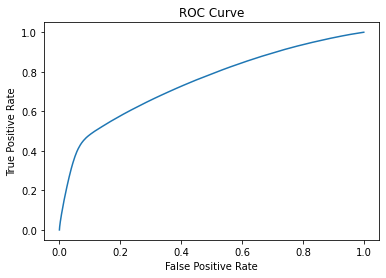

Training set area Under ROC: 0.747232697507722
Test Area Under ROC 0.7346426776838653
---------------------------------------
F1 = 0.814839367836903
---------------------------------------
Confusion matrix, without normalization
[[486353 16371]
 [ 80444 30365]]

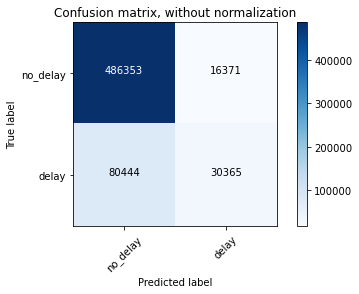

Normalized confusion matrix
[[0.96743541 0.03256459]
 [0.72596991 0.27403009]]

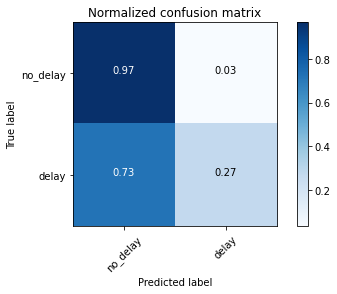

precision recall f1-score support

 no_delay 0.86 0.97 0.91 502724
 delay 0.65 0.27 0.39 110809

 accuracy 0.84 613533
 macro avg 0.75 0.62 0.65 613533
weighted avg 0.82 0.84 0.81 613533

0.8422008270133798

In [0]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set area Under ROC: ' + str(trainingSummary.areaUnderROC))

evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

# Calculate Metric
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

measure = evaluator.evaluate(predictions)
print("---------------------------------------")
print("F1 = %s" % (measure))
print("---------------------------------------")

# Get Predicted VS Actual
y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred)

# Plot non-normalized confusion matrix
plt.figure()
class_names = ['no_delay','delay']
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')
plt.show()

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))
print(accuracy_score(y_true, y_pred))

Only 27% of departure delays are detected.

### Modeling improvements

Improve the logistic regression model and explore algorithms that can better handle the non-linear relationship between the predictors and the outcome variable:

- Decision Trees (DT).
- Gradient-Boosted Tree (GBT).

In [0]:
#SET CONTEXT
sc = spark.sparkContext
sqlContext = SQLContext(sc)

#GET DATA
df = sqlContext.sql("""SELECT * FROM features_final""")

In [0]:
#SELECT FEATURES - NUMERIC
numericCols = ['DAY_OF_MONTH', 'DAY_OF_WEEK', 'YEAR', 'QUARTER', 'MONTH', 'H_DEP', 'flight_aircraft', 'ORPageRank', 'proxy_origin', 
               'DESTPageRank', 'proxy_dest', 'carrier_delay', 'airport_delay', 'DISTANCE', 'dep_delay_aircraft']

#SELECT FEATURES - CATEGORICAL
categoricalColumns = ['OP_CARRIER']

#### Model Data Pipeline

Create a pipeline to prepare the data for modeling: 
- Rescale numerical features.
- Create indexer for categorical variable.
- Create indexer for the label column.
- One-hot encode categorical variable.
- Create one column that contains a vector with all features of the model.

In [0]:
#ALL COLUMNS
cols = df.columns

#VECTORIZE NUMERIC COLS
assembler = VectorAssembler(inputCols=numericCols, outputCol="Numfeatures")
df = assembler.transform(df)

#MIN-MAX-SCALER
Scaler = MinMaxScaler(inputCol="Numfeatures", outputCol="scaledFeatures")
df = Scaler.fit(df).transform(df)

#CAT COLUMNS
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder (inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
    
#LABELS
label_stringIdx = StringIndexer(inputCol = 'DEP_DEL15', outputCol = 'label')
stages += [label_stringIdx]

#ASSEBLER
assemblerInputs = [c + "classVec" for c in categoricalColumns] 
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="featuresCat")
stages += [assembler]

#PIPELINE
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'featuresCat'] + cols + ['Numfeatures','scaledFeatures']
df = df.select(selectedCols)

#Create a vector of features with categorical variables and scaled features
assembler = VectorAssembler(inputCols=["featuresCat", "scaledFeatures"],outputCol="features")
df = assembler.transform(df)

#### Split data into training, development and test sets

All the data but the last 2 months is used for training. The last 2 months of 2019 are split into test and development sets to run prediction on more recent data. This represents a rolling window where the model is always tested with the most recent data and trained with all remaining data.

In [0]:
# Train data is all data but the last 2 months
train = df.where(col('MONTH')<= 10)
print(f'{train.count():} records in train data')

# Development and test data on the last 2 months
test, dev = (df.where((col('MONTH')>10))).randomSplit([0.5,0.5],seed=1)
print(f'{test.count():} records in test data')  
print(f'{dev.count():} records in dev data')


6177012 records in train data
613533 records in test data
613655 records in dev data

#### Data imbalance

Data is imbalanced. There are 4 times more records of flights delayed than not delayed. Will oversample minority class in the training set.

In [0]:
# calculate the ratio of the classes
df_minority = df.where(col('DEP_DEL15') == 1)
df_majority = df.where(col('DEP_DEL15') == 0)
major = df_majority.count()
minor = df_minority.count()
ratio = int(major/minor)
print(f'There are {ratio} times more flights not delayed than flights delayed')
print(f'Number of records of flights delayed: {minor}')
print(f'Number of records of flights not delayed: {major}')

There are 4 times more flights not delayed than flights delayed
Number of records of flights delayed: 1476497
Number of records of flights not delayed: 5927703

In [0]:
# Oversample minority class using UDF
train = sample_df(train,ratio,1)

Oversampling minority class results in:
Number of flights delayed: 5020252
Number of flights not-delayed: 4921949
Ratio: 0.9804187120487179

#### Logistic Regression

Use cross-validation to optimize the hyperparameter selection for logistic regression and select best combination of hyperparameters.

Parameters considered during cross validation:
- elasticNetParam: elasticNet parameter for mixing in the range between alpha = 0 to 1. Where alpha = 0, the penalty is an L2 penalty. alpha =1, it is an L1 penalty (default = 0)
- regParam: regularization parameter (default = 0)
- maxIter: maximum number of iterations (default = 100)
- threshold: threshold for classification in range of 0 to 1 (default = 0.5)
- family: family for the label distribution, it can be auto, binomial or multinomial (default = auto)
- standardization: tells the model to standardize the data before fitting the model (default = True)
- fitIntercept: tells the model whether to fit the intercept term (default = True)
- aggregationDepth: the depth for TreeAggregate (default = 2)

In [0]:
# Define the Model
model = LogisticRegression(featuresCol = 'features', labelCol = 'label')

# Define the parameter grid to examine.
paramGrid = ParamGridBuilder() \
  .addGrid(model.maxIter,[100])\
  .addGrid(model.regParam, [0.0]) \
  .addGrid(model.elasticNetParam, [0.0]) \
  .build()

#  .addGrid(model.regParam, [0.0, 0.5]) \
#  .addGrid(model.elasticNetParam, [0 , 0.5 , 1.0]) \
#  .addGrid(model.family, ['multinomial','binomial']) \
#  .addGrid(model.standardization, [True,False]) \
#  .addGrid(model.fitIntercept,[False, True])\
#  .addGrid(model.threshold, [0.5]) \
#  .addGrid(model.aggregationDepth,[2,5,10])\

# Create an evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# Declare the CrossValidator
cv = CrossValidator(estimator=model, evaluator=evaluator, estimatorParamMaps=paramGrid, numFolds=3)

# Build PipeLine
pipeline = Pipeline(stages=[cv])

# Run Cross-Validation
with mlflow.start_run(run_name='LogisticRegression'):
  # Run the cross validation on the training dataset. 
  pipelineModel = pipeline.fit(train)
  
  # Evaluate the best model's performance on the test dataset
  dev_metric = evaluator.evaluate(pipelineModel.transform(dev))
#   mlflow.log_metric('dev_' + evaluator.getMetricName(), dev_metric) 

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

Test Area Under ROC 0.7496996192655967
Accuracy 0.7835694679346771
F1 0.7947492700434902
Confusion matrix, without normalization
[[418461 84381]
 [ 48321 61976]]

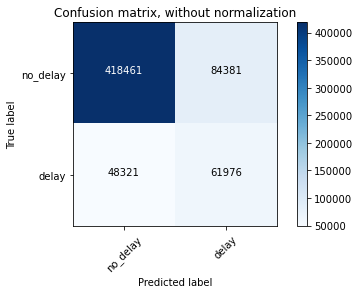

Normalized confusion matrix
[[0.83219182 0.16780818]
 [0.43809895 0.56190105]]

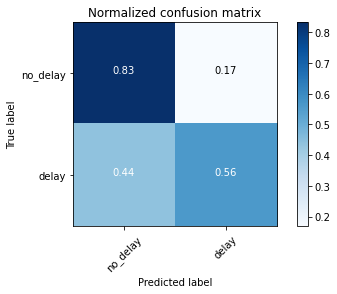

precision recall f1-score support

 no_delay 0.90 0.83 0.86 502842
 delay 0.42 0.56 0.48 110297

 accuracy 0.78 613139
 macro avg 0.66 0.70 0.67 613139
weighted avg 0.81 0.78 0.79 613139

Accuracy = 0.7835694679346771

In [0]:
# Use the model identified by the cross-validation to make predictions on the test dataset
predictions = pipelineModel.transform(test)

# Get AUC - ROC
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print('Test Area Under ROC', evaluator.evaluate(predictions))

# Get Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
print("Accuracy ", evaluator.evaluate(predictions))

# Get F1
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
print("F1 ", evaluator.evaluate(predictions))

# Get Predicted VS Actual
y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred)

# Plot non-normalized confusion matrix
plt.figure()
class_names = ['no_delay','delay']
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')
plt.show()

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')
plt.show()

# Print Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

# Print Accuracy
print("Accuracy = ", accuracy_score(y_true, y_pred))

The improved logistic regression model correctly detects departure delays in 56% of the cases (from 27% in the baseline model). The weighted f-1 score goes down to 0.79 from 0.81. The model gets better at predicting delays but worse at predicting no delays.

#### Decision Tree

Use cross-validation to optimize the hyperparameter selection for the decision tree model and select best combination of hyperparameters.

Parameters considered during cross validation:

- impurity: Impurity measure used to choose between candidate splits (default = gini)
- maxDepth: Maximum depth of a tree. Deeper trees are more expressive (potentially allowing higher accuracy), but they are also more costly to train and are more likely to overfit (default = 5)
- maxBins: Number of bins used when discretizing continuous features (default = 32)

In [0]:
# Define the Model
model = DecisionTreeClassifier(labelCol="label", featuresCol="features")

# Define the parameter grid to examine.
paramGrid = ParamGridBuilder() \
  .addGrid(model.impurity, ['entropy']) \
  .addGrid(model.maxDepth, [20]) \
  .build()

#  .addGrid(model.impurity, ['entropy','gini']) \
#  .addGrid(model.maxDepth, [3, 10]) \
#  .addGrid(model.maxBins, [3, 20]) \

# Create an evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# Declare the CrossValidator
cv =CrossValidator(estimator=model, evaluator=evaluator, estimatorParamMaps=paramGrid, numFolds=3)

# Build PipeLine
pipeline = Pipeline(stages=[cv])

In [0]:
with mlflow.start_run(run_name='DecisionTreeClassifier'):
  # Run the cross validation on the training dataset. 
  pipelineModel = pipeline.fit(train)
  
  # Evaluate the best model's performance on the test dataset
  test_metric = evaluator.evaluate(pipelineModel.transform(dev))
#   mlflow.log_metric('test_' + evaluator.getMetricName(), test_metric) 

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

Test Area Under ROC 0.5691610438530824
Accuracy 0.771681462115442
F1 0.7850746364205042
Confusion matrix, without normalization
[[411619 91223]
 [ 48768 61529]]

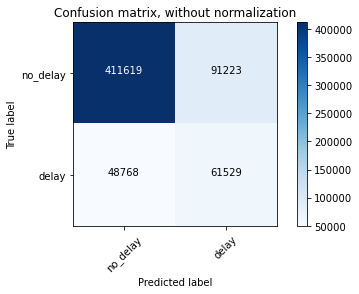

Normalized confusion matrix
[[0.81858516 0.18141484]
 [0.44215165 0.55784835]]

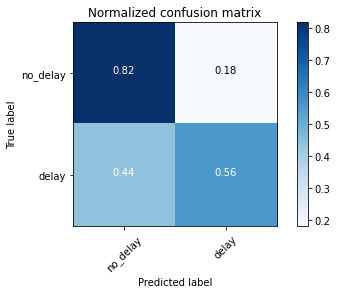

precision recall f1-score support

 no_delay 0.89 0.82 0.85 502842
 delay 0.40 0.56 0.47 110297

 accuracy 0.77 613139
 macro avg 0.65 0.69 0.66 613139
weighted avg 0.81 0.77 0.79 613139

Accuracy = 0.771681462115442

In [0]:
# Use the model identified by the cross-validation to make predictions on the test dataset
predictions = pipelineModel.transform(test)

# Get AUC - ROC
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print('Test Area Under ROC', evaluator.evaluate(predictions))

# Get Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
print("Accuracy ", evaluator.evaluate(predictions))

# Get F1
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
print("F1 ", evaluator.evaluate(predictions))

# Get Predicted VS Actual
y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred)

# Plot non-normalized confusion matrix
plt.figure()
class_names = ['no_delay','delay']
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')
plt.show()

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')
plt.show()

# Print Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

# Print Accuracy
print("Accuracy = ", accuracy_score(y_true, y_pred))

The decision tree achieves similar levels of performance compared with logistic regression. The next section explores ensembles of trees using Gradient-Boosted Trees (GBTs)

#### GBT Classifier

Use cross-validation to optimize the hyperparameter selection for the gradient-boosted tree classifier and select best combination of hyperparameters.

Parameters considered during cross validation:
- maxIter: This sets the number of trees in the ensemble. Each iteration produces one tree. Increasing this number makes the model more expressive, improving training data accuracy. However, test-time accuracy may suffer if this is too large.
- maxDepth: Maximum depth of a tree. Deeper trees are more expressive (potentially allowing higher accuracy), but they are also more costly to train and are more likely to overfit
- maxBins: Number of bins used when discretizing continuous features

In [0]:
# Define the Model
model = gbt = GBTClassifier()

# Define the parameter grid to examine.
paramGrid = ParamGridBuilder() \
  .addGrid(model.maxIter, [100]) \
  .addGrid(model.maxDepth, [10]) \
  .build()

# Create an evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# Declare the CrossValidator
cv = CrossValidator(estimator=model, evaluator=evaluator, estimatorParamMaps=paramGrid, numFolds=3)

# Build PipeLine
pipeline = Pipeline(stages=[cv])

In [0]:
with mlflow.start_run(run_name='GBTClassifier'):
  # Run the cross validation on the training dataset. 
  pipelineModel = pipeline.fit(train)
  
  # Evaluate the best model's performance on the test dataset and log the result.
  test_metric = evaluator.evaluate(pipelineModel.transform(dev))
#   mlflow.log_metric('test_' + evaluator.getMetricName(), test_metric) 

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

Test Area Under ROC 0.7862551055003584
Accuracy 0.8033094879150291
F1 0.8118589162719749
Confusion matrix, without normalization
[[428003 75141]
 [ 45673 65417]]

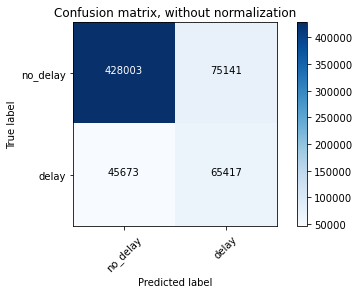

Normalized confusion matrix
[[0.85065707 0.14934293]
 [0.41113512 0.58886488]]

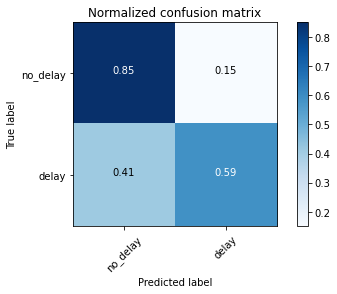

precision recall f1-score support

 no_delay 0.90 0.85 0.88 503144
 delay 0.47 0.59 0.52 111090

 accuracy 0.80 614234
 macro avg 0.68 0.72 0.70 614234
weighted avg 0.82 0.80 0.81 614234

Accuracy = 0.8033094879150291

In [0]:
# Use the model identified by the cross-validation to make predictions on the test dataset
predictions = pipelineModel.transform(test)
  
# Get AUC - ROC
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print('Test Area Under ROC', evaluator.evaluate(predictions))

# Get Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
print("Accuracy ", evaluator.evaluate(predictions))

# Get F1
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
print("F1 ", evaluator.evaluate(predictions))

# Get Predicted VS Actual
y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred)

# Plot non-normalized confusion matrix
plt.figure()
class_names = ['no_delay','delay']
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')
plt.show()

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')
plt.show()

# Print Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

# Print Accuracy
print("Accuracy = ", accuracy_score(y_true, y_pred))

#### Feature Importance

A benefit of using a tree-based algorithm is that we can use the feature importance function to get the estimates of feature importance from the trained predictive model.    
The importance score provides how useful a feature was in construction of the model. The more a feature is used to make key decisions within the tree the higher its relative importance.

In [0]:
gbt = GBTClassifier(maxIter=100,maxDepth=10)
gbtModel = gbt.fit(train)

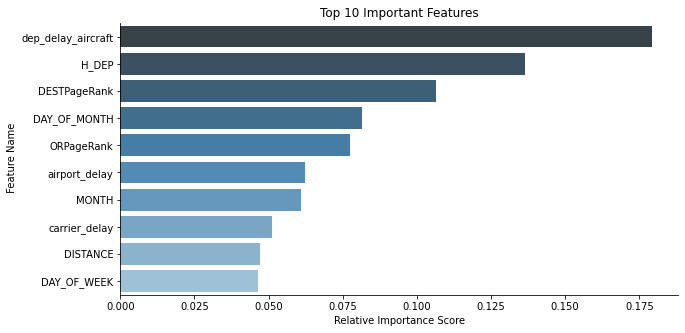

In [0]:
feature_imp = ExtractFeatureImp(gbtModel.featureImportances, train, "features")
feature_imp['index1'] = feature_imp.index
feature_imp['feature_name'] = feature_imp['index1'].apply(addColumnImp)
feature_imp.loc[feature_imp["feature_name"] == "NA","feature_name"] = feature_imp["name"]
feature_imp = feature_imp.head(10)

ax = plt.figure(figsize=(10, 5),frameon =True)
ax = sns.barplot(x=feature_imp['score'], y=feature_imp['feature_name'], palette="Blues_d")
ax.set(xlabel='Relative Importance Score', ylabel=' Feature Name',title="Top 10 Important Features")
sns.despine()
plt.yticks(rotation=0) 
plt.xticks(rotation=0) 
plt.show()

As we can observe, the most important feature is one that measures aircraft delays due to previous flight delays. The second most important feature is the hour of departure of the flight. Origin and destination airport's importance, measured using the PageRank statistic, are the third and fifth most important features. Other features in the top ten list are: day of the month, previous delays at the origin airport, month, previous carrier delays, flight's distance and day of the week.

## Conclusions

The exploratory data analysis clearly pointed to non-linearities in correlation between the predictors and a flight's delay.

The logistic regression baseline model has a relatively high weighted f-1 score (0.81), but predicts poorly delayed flights. The high f-1 score is due to its good performance in the majority class (not delayed flights).

Once data is balanced and better hyperparameters are selected, the logistic regression model achieves better results predicting delayed flights, but the performance predicting not delayed flights is reduced. The decision tree model exhibits a similar performance.

Not surprisingly, the Gradient-Boosted Trees model performed better compared with logistic regression and single decision tree models, predicting both delayed and not delayed flights.

These models could be further improved by implementing additional methods. The underbalanced aspects of the data could be supplanted with better methods of synthetic data generation (eg.SMOTE). Also, weather data associated to the overall flight itinerary could be included in the model.

## References

1. Airport’s location dataset: https://data.humdata.org/dataset/ourairports-usa
2. Dictionary for airlines dataset: https://www.transtats.bts.gov/DL_SelectFields.asp?gnoyr_VQ=FGJ